# Popularity of Baby Names
Analysis of the popularity of baby names using data from the SSA.gov dataset.

In [ ]:
import io, os, requests, zipfile

url="https://www.ssa.gov/oact/babynames/names.zip"
directory="./data/"
namesDirectory=os.path.join(directory, "names")

if not os.path.exists(namesDirectory):
    r = requests.get(url)
    assert r.ok
    with zipfile.ZipFile(io.BytesIO(r.content)) as zip:
        zip.extractall(namesDirectory)

Combine the yearly data into a single CSV. Filter to a single gender while we're at it, mostly because it simplifies the name key in the dictionary I'm using to combine data.


In [ ]:
startYear=1921
endYear=2021

combined_filename=os.path.join(directory, f"combined-{startYear}-{endYear}.csv")
if not os.path.exists(combined_filename):

    # Read all the names from each year between start..end
    #    1. Merge into a single CSV keyed by Name + Sex
    #    2. Write to a new csv file with a column per year
    all_the_names={}
    for year in range(startYear, endYear + 1):
        filename=os.path.join(namesDirectory, f"yob{year}.txt")
        with open(filename, "r") as names:
            for line in names:
                name, sex, count = line.split(",")
                key = (str.strip(name), str.strip(sex))
                count = int(count)

                if key not in all_the_names.keys():
                    all_the_names[key] = {}

                all_the_names[key][year] = count
    
    with open(combined_filename, "w") as combined_csv:
        combined_csv.write("Name,Sex")
        for year in range(startYear, endYear + 1):
            combined_csv.write(f",{year}")
        combined_csv.write("\n")

        for key, counts in all_the_names.items():
            name, sex = key
            combined_csv.write(f"{name},{sex}")
            for year in range(startYear, endYear + 1):
                combined_csv.write(f",{0 if year not in counts.keys() else counts[year]}")
            combined_csv.write("\n")

Load the combined file into a Pandas Dataframe. Split the dataframe by gender and normalize to *approximately* the count per million. Disclaimer: I don't know this data was sampled.

In [ ]:
import numpy as np
import pandas as pd

names = pd.read_csv(combined_filename).set_index(['Sex', 'Name'])

names_female = names[names.index.get_level_values('Sex') == "F"]
names_female = pd.concat([(1_000_000 * series / series.sum()).round().astype(int) for header, series in names_female.items()], axis=1)

names_male = names[names.index.get_level_values('Sex') == "M"]
names_male = pd.concat([(1_000_000 * series / series.sum()).round().astype(int) for header, series in names_male.items()], axis=1)

names = pd.concat([names_female, names_male])

# Fuzzy Name Matching

Many names in the SSA.gov dataset are the same phonetic name with different spellings. This section uses the Fuzzy phonetic matching algorithm to group names phonetically.

In [73]:
import fuzzy

algorithm = fuzzy.nysiis
algorithm_name = 'nysiis'

yearToFuzz="2021"

fuzzy_filename=os.path.join(directory, f"fuzzy-{algorithm_name}-{yearToFuzz}.csv")

if not os.path.exists(fuzzy_filename):
    names_fuzzy = names[yearToFuzz].reset_index()
    names_fuzzy[algorithm_name] = names_fuzzy['Name'].apply(algorithm)

    # Group rows by their phonetic spelling
    # Count all alternative spellings together
    # Take the most common spelling as the representitive name, but print out alternatives too
    with open(fuzzy_filename, "w") as fuzzy_csv:
        fuzzy_csv.write("Name,Sex,PhoneticName,Count,Alternate Spellings, Alternate Spelling Details\n")
        for key, group in names_fuzzy.groupby(by=['Sex', algorithm_name]):
            sex, phonetic_name = key
            sorted_group = group[group[yearToFuzz] > 0].sort_values(by=yearToFuzz, ascending=False)

            # Only count groups that have at least one spelling for this year
            row_count = len(sorted_group.index)
            if (row_count == 0):
                continue

            most_common = sorted_group.iloc[0]
            most_common_name = most_common['Name']

            group_sum = sorted_group[yearToFuzz].sum()
            group_alternate_spellings_count = row_count - 1
            group_summary = str.join('/', [ f"{row['Name']}({row[yearToFuzz]})" for key, row in sorted_group.iterrows()])

            fuzzy_csv.write(f"{most_common_name},{sex},{phonetic_name},{group_sum},{group_alternate_spellings_count},{group_summary}\n")

names_fuzzy = pd.read_csv(fuzzy_filename).set_index(['Sex', 'Name'])

names_female_fuzzy = names_fuzzy[names_fuzzy.index.get_level_values('Sex') == "F"]
names_male_fuzzy = names_fuzzy[names_fuzzy.index.get_level_values('Sex') == "M"]

## Fuzzy Name Analysis

Which names have the most alternate spellings?
Which names 

In [77]:
names_fuzzy.nlargest(25, columns= 'Alternate Spellings')


PhoneticName  Count  Alternate Spellings  \
Sex Name                                                
F   Kehlani         CALAN   6449                  155   
    Alina            ALAN   8328                  121   
    Cheyenne          CAN   2542                  121   
    Remi              RAN   6075                  121   
    Luna              LAN   9505                  118   
    Sienna            SAN   3126                  113   
    June              JAN   5538                  110   
    Cora              CAR   6830                  104   
M   Colin           CALAN   6225                  102   
F   Kali              CAL   3725                  100   
    Eliana           ELAN  10611                   97   
    Anna               AN   6074                   96   
    Milani          MALAN   3766                   95   
    Amelia           ANAL  10172                   94   
M   Cohen             CAN   4278                   92   
F   Amara            ANAR   5400                   86   
    Kylie            CALY   4471                   82   
    Mila              MAL   7074                   80   
M   Ryan              RAN   7707                   79   
F   Lillian         LALAN   8644                   78   
M   Kason           CASAN   3087                   77   
F   Juliana         JALAN   3309                   76   
    Noelle            NAL   4044                   75   
    Diana             DAN   3395                   74   
    Sarah             SAR   5432                   70   

                                     Alternate Spelling Details  
Sex Name                                                         
F   Kehlani   Kehlani(1145)/Kailani(696)/Collins(613)/Kalani...  
    Alina     Alina(1240)/Alani(983)/Alaina(916)/Alana(814)/...  
    Cheyenne  Cheyenne(275)/Kenna(247)/Kiana(221)/Chana(214)...  
    Remi      Remi(1406)/Rowan(770)/Wren(749)/Ryan(388)/Rein...  
    Luna      Luna(5023)/Lena(666)/Lana(508)/Liana(474)/Leon...  
    Sienna    Sienna(1149)/Siena(297)/Sonia(117)/Sanai(86)/S...  
    June      June(1026)/Jane(715)/Joanna(669)/Jenna(316)/Je...  
    Cora      Cora(1837)/Kiara(605)/Kira(495)/Keira(406)/Kor...  
M   Colin     Colin(739)/Callum(725)/Killian(537)/Callan(495...  
F   Kali      Kali(685)/Cali(589)/Kyla(383)/Celia(218)/Kalea...  
    Eliana    Eliana(2720)/Elena(2613)/Elliana(1306)/Elaina(...  
    Anna      Anna(1871)/Ana(779)/Anya(349)/Anne(312)/Amaia(...  
    Milani    Milani(644)/Malani(458)/Melina(286)/Milan(278)...  
    Amelia    Amelia(7960)/Analia(351)/Amalia(342)/Amal(148)...  
M   Cohen     Cohen(684)/Kane(573)/Kian(384)/Keanu(317)/Kohe...  
F   Amara     Amara(1173)/Amira(828)/Amari(597)/Amora(482)/A...  
    Kylie     Kylie(1103)/Callie(1021)/Kaliyah(336)/Kylee(28...  
    Mila      Mila(3869)/Myla(794)/Malia(737)/Mylah(367)/Mal...  
M   Ryan      Ryan(2712)/Rowan(2086)/Romeo(533)/Rowen(313)/R...  
F   Lillian   Lillian(2644)/Leilani(2126)/Liliana(1592)/Lill...  
M   Kason     Kason(416)/Kaison(368)/Kyson(365)/Kasen(362)/C...  
F   Juliana   Juliana(869)/Julianna(647)/Jolene(419)/Jillian...  
    Noelle    Noelle(902)/Nyla(807)/Nylah(481)/Nola(307)/Nal...  
    Diana     Diana(812)/Demi(515)/Danna(513)/Dani(236)/Dana...  
    Sarah     Sarah(1736)/Sara(926)/Sawyer(842)/Sarai(419)/S...

## Top Name Trends
Plot the popularity of the top 10 names from certain years.

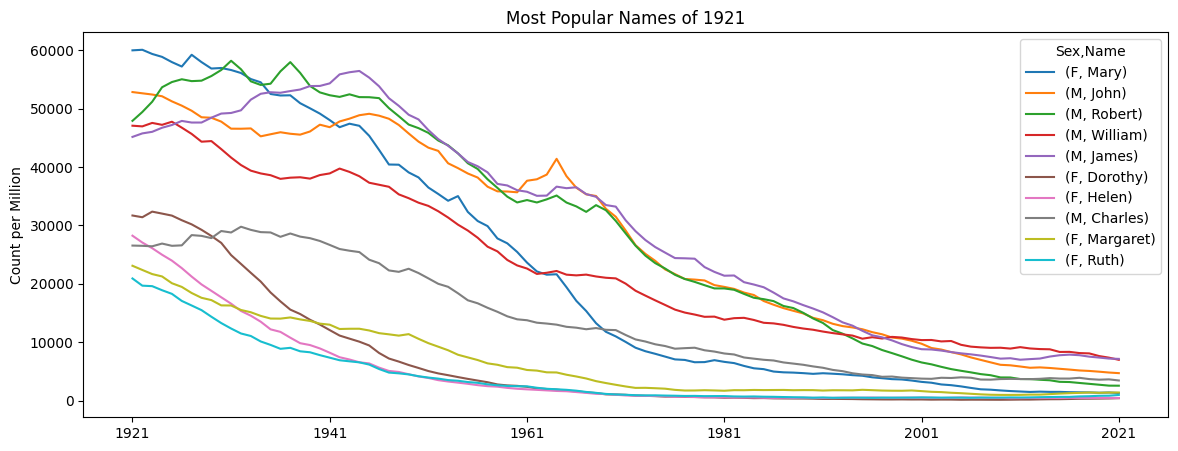

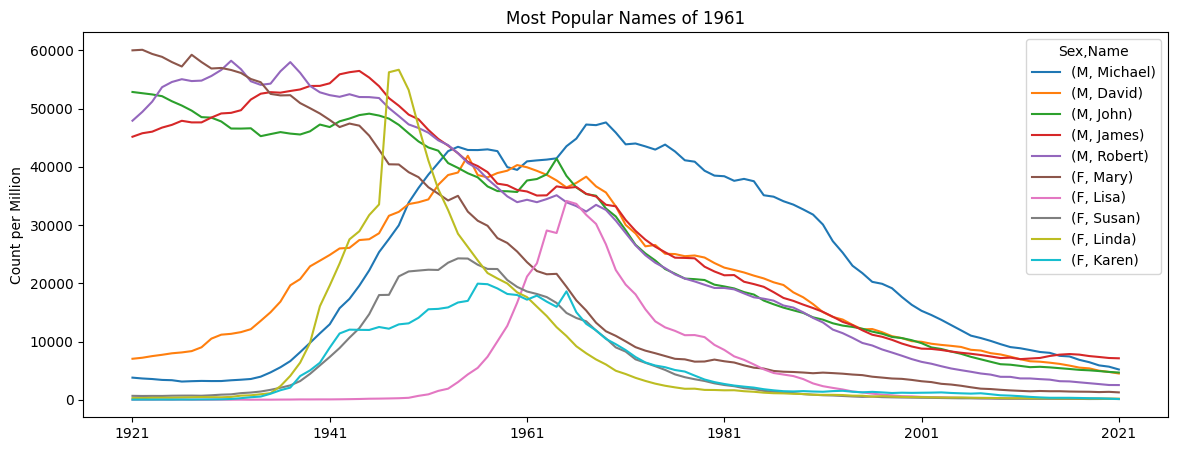

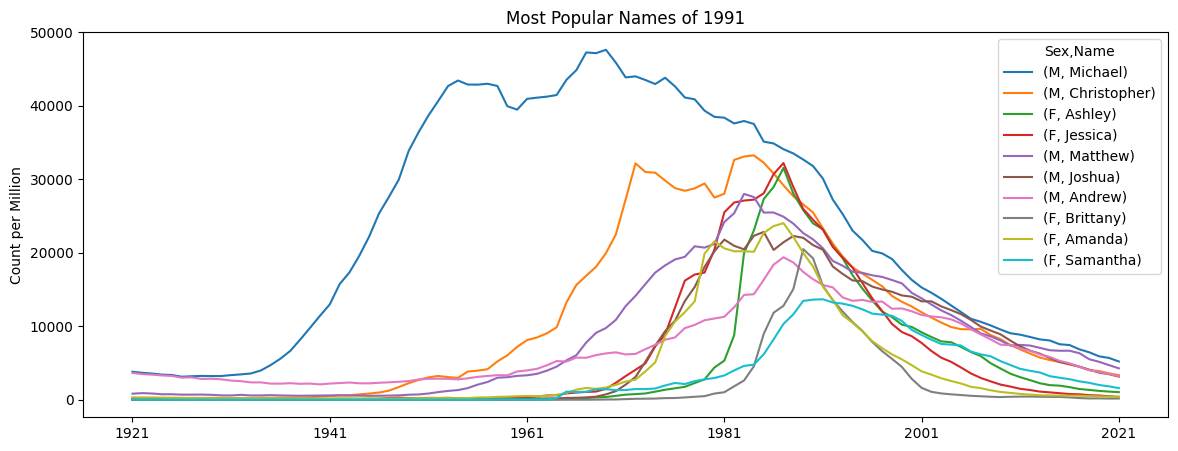

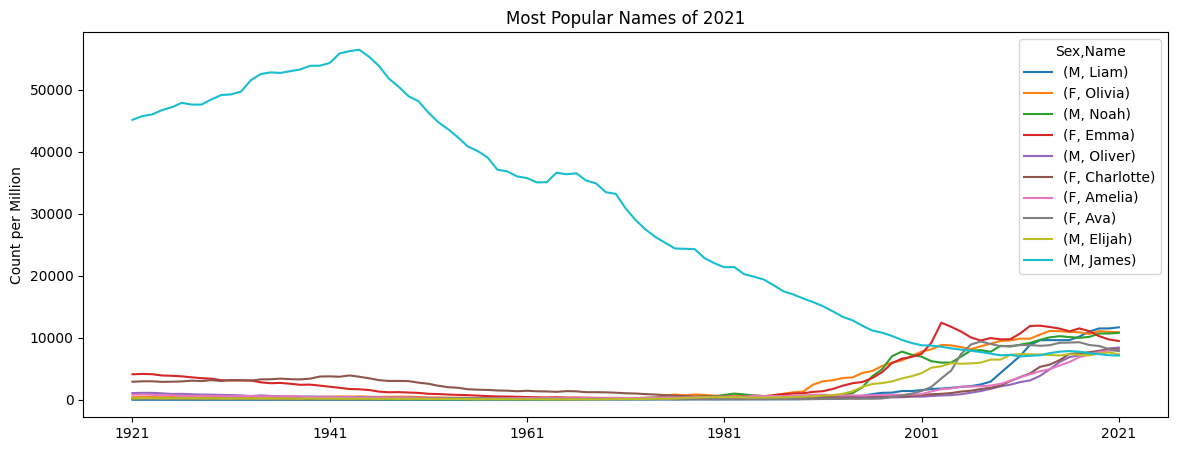

In [74]:
yearsToPlot = [ 1921, 1961, 1991, 2021 ]

for year in yearsToPlot:
    topFemaleNames = names_female.nlargest(5, f"{year}")
    topMaleNames = names_male.nlargest(5, f"{year}")
    pd.concat([topFemaleNames,topMaleNames]) \
        .sort_values(by=f"{year}", ascending=False) \
        .transpose() \
        .plot(title=f"Most Popular Names of {year}", ylabel="Count per Million", figsize=(14,5))


## Specific Names Trends

Plot specific names over time

<AxesSubplot: title={'center': 'Name Popularity from 1921 to 2021'}, ylabel='Count per Million'>

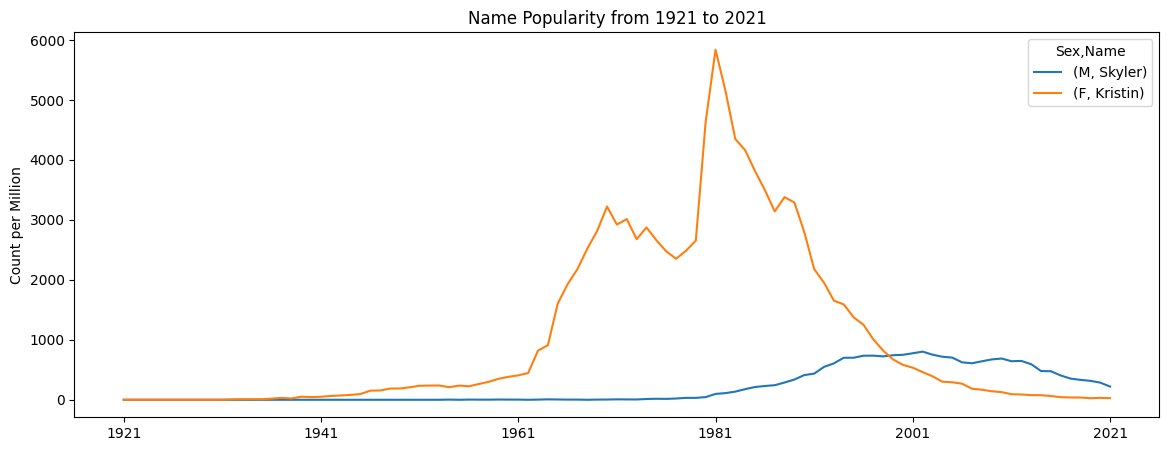

In [76]:
names_to_plot = [ ('M', 'Skyler'), ('F', 'Kristin') ] 
names.loc[names_to_plot] \
    .sort_values(by=f"{year}", ascending=False) \
    .transpose() \
    .plot(title=f"Name Popularity from {startYear} to {endYear}", ylabel="Count per Million", figsize=(14,5))